In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from random import randint
import math 

## Algorithme génétique pour le probleme du voyageur de commerce

***Probleme :***

. Soit un graphe non orienté complet valué (tous les sommets sont connectés entre
eux avec des arretes à cout positif) contenant n sommets.
. Extraire un circuit Hamiltonien le plus court (passant par tous les sommets du
graphe une et une seule fois)


## ***Quelques indications :***

* .Individu = un circuit quelconque (passage par tous les sommets du graphe)

* . Fonction d'evaluation : La valeur d'adaptation doit etre croissante avec l'adaptation de la solution du probleme .

* . La valeur d'adaptation est inversement proportionnel à la distance du chemin de chaque individu (car on cherche le circuit Hamiltonien le plus court)



### References 

 * http://deptinfo.unice.fr/twiki/pub/Linfo/PlanningDesSoutenances20032004/Radet-Souquet.pdf

 * https://www.ripublication.com/ijcir17/ijcirv13n7_15.pdf
 
 * https://www.researchgate.net/publication/282733130_Analyse_des_performances_d'operateurs_de_mutation_genetique_a_la_resolution_du_Probleme_de_Voyageur_de_Commerce

In [2]:
nb_sommets=4
poids_max=12

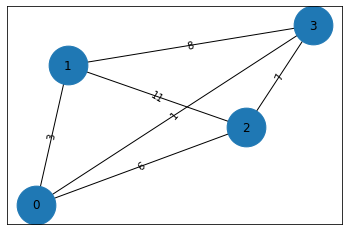

In [3]:
G=nx.Graph()

G.add_weighted_edges_from( (i,j,randint(1,poids_max)) for i in range(nb_sommets) for j in range(i+1,nb_sommets))

G.edges(data=True)

edge_labels=dict([((u,v,),d['weight'])for u,v,d in G.edges(data=True)])
pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx(G,pos, node_size=1500,edge_cmap=plt.cm.Reds)
pylab.show()  

In [4]:
"""
  Tous les somments sont connectés entre eux avec des aretes à coût positif
  donc on fait l'ensemble des chemin pour chaque sommet
  
"""
def ajouter_les_poids(genes,edge_labels):
    res=[]
    for ind in genes:
        new_ind={}
        for i in range(len(ind)-1):
            if (ind[i],ind[i+1]) not in list(edge_labels.keys()):
                if (ind[i+1],ind[i]) in list(edge_labels.keys()):
                    new_ind[(ind[i+1],ind[i])]=edge_labels[(ind[i+1],ind[i])]
            else:
                new_ind[(ind[i],ind[i+1])]=edge_labels[(ind[i],ind[i+1])]
                
        res.append(new_ind)
    return res
    
def create_population(G,edge_labels):
    genes = []
    for node in G.nodes():
        for n in G.nodes():
            for path in nx.all_simple_paths(G, source=node, target=n):
                if len(path)==len(G.nodes()):
                    genes.append(path)
    return ajouter_les_poids(genes,edge_labels)

In [5]:
create_population(G,edge_labels)



[{(0, 2): 6, (2, 3): 7, (1, 3): 8},
 {(0, 3): 1, (2, 3): 7, (1, 2): 11},
 {(0, 1): 3, (1, 3): 8, (2, 3): 7},
 {(0, 3): 1, (1, 3): 8, (1, 2): 11},
 {(0, 1): 3, (1, 2): 11, (2, 3): 7},
 {(0, 2): 6, (1, 2): 11, (1, 3): 8},
 {(1, 2): 11, (2, 3): 7, (0, 3): 1},
 {(1, 3): 8, (2, 3): 7, (0, 2): 6},
 {(0, 1): 3, (0, 3): 1, (2, 3): 7},
 {(1, 3): 8, (0, 3): 1, (0, 2): 6},
 {(0, 1): 3, (0, 2): 6, (2, 3): 7},
 {(1, 2): 11, (0, 2): 6, (0, 3): 1},
 {(1, 2): 11, (1, 3): 8, (0, 3): 1},
 {(2, 3): 7, (1, 3): 8, (0, 1): 3},
 {(0, 2): 6, (0, 3): 1, (1, 3): 8},
 {(2, 3): 7, (0, 3): 1, (0, 1): 3},
 {(0, 2): 6, (0, 1): 3, (1, 3): 8},
 {(1, 2): 11, (0, 1): 3, (0, 3): 1},
 {(1, 3): 8, (1, 2): 11, (0, 2): 6},
 {(2, 3): 7, (1, 2): 11, (0, 1): 3},
 {(0, 3): 1, (0, 2): 6, (1, 2): 11},
 {(2, 3): 7, (0, 2): 6, (0, 1): 3},
 {(0, 3): 1, (0, 1): 3, (1, 2): 11},
 {(1, 3): 8, (0, 1): 3, (0, 2): 6}]

In [6]:
def fitness (population):
    cout_list = []
    somme = []
    for i  in range(len(population)):
        inter= population[i].values()
        cout_list.append(inter) #recupération des coûts dans une liste
        inter_somme = sum(cout_list[i]) #calcul de la somme des coûts(distances) d'un chemin ou d'un cycle
        somme.append(inter_somme)
    print("somme", somme)
    cout_minim = min(somme) #recherche de la  plus petite somme de coût
    index_value = somme.index(cout_minim) 
    print("Coût minimum :", cout_minim )
    return population[index_value]
    

In [7]:
fitness(create_population(G,edge_labels))

somme [21, 19, 18, 20, 21, 25, 19, 21, 11, 15, 16, 18, 20, 18, 15, 11, 17, 15, 25, 21, 18, 16, 15, 17]
Coût minimum : 11


{(0, 1): 3, (0, 3): 1, (2, 3): 7}

In [10]:
def croisement(population):
    parent1 = random.choice(population)
    parent2 = random.choice(population)
    print(parent1)
    

In [11]:
croisement(create_population(G,edge_labels))

{(1, 2): 7, (0, 1): 12, (0, 3): 5}


In [26]:
def Mutation(population):
    lst=[]
    enfant={}
    parent = random.choice(population)
    print("parent", parent)
    P = 1
    nbre = random.random()
    if nbre < P:
        tup = list(parent.keys())
        key1 = tup[0]
        key2 = tup[1]
        key3 = tup[2]
        if  key1[0]!= key2[1]and key1[1]!=key2[1]:
            new1 = (key1[0], key2[1])
            if key1[1]!=key2[0]:
                new2 = (key2[0],key3[1])
                new3 = (key3[0],key1[1])
                lst= [new1, new2, new3]
                for i in range(len(tup)-3):
                    lst.append(tup[i+3])

    for cle in lst:
        for ind in population:
            if cle in ind.keys():
                enfant[cle]= ind[cle]
                break
    if len(enfant.keys()) == len(parent.keys()):
        print("Enfant :")
        return enfant
    else:
        return parent
        
        
     
    
                

In [31]:
Mutation(create_population(G,edge_labels))

parent {(0, 2): 6, (0, 1): 3, (1, 3): 8}
Enfant :


{(0, 1): 3, (0, 3): 1, (1, 2): 11}